<a href="https://colab.research.google.com/github/jrbobes/jrbobes-hitl-ml/blob/master/20230906_PAAD_XAI_XOVETIC_2023.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **TCGA-PAAD - XAI - XOVETIC 2023**

author: jose.bobes at udc.es

# Importing required libraries

In [1]:
# Importing Required Libraries
import sys
print('Python: {}'.format(sys.version))

import scipy
print('scipy: {}'.format(scipy.__version__))

import numpy as np
print('numpy: {}'.format(np.__version__))

import matplotlib
import matplotlib.pyplot as plt
print('matplotlib: {}'.format(matplotlib.__version__))

import pandas as pd
print('pandas: {}'.format(pd.__version__))

import sklearn
print('sklearn: {}'.format(sklearn.__version__))

from sklearn import metrics
from sklearn import tree

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

Python: 3.10.12 (main, Jun 11 2023, 05:26:28) [GCC 11.4.0]
scipy: 1.10.1
numpy: 1.23.5
matplotlib: 3.7.1
pandas: 1.5.3
sklearn: 1.2.2


# Cleaning the Pancreas dataset

In [2]:
# 1. Loading Data
url = "https://raw.githubusercontent.com/jrbobes/jrbobes-hitl-ml/master/tcga-paad-inicial.csv"
#columns = ['ajcc_pathologic_stage', 'ajcc_pathologic_t', 'ajcc_pathologic_m', 'ajcc_pathologic_n', 'primary_diagnosis', 'tissue_or_organ_of_origin', 'age_at_index', 'gender', 'days_to_death', 'therapy_type']
columns = ['ajcc_pathologic_stage', 'ajcc_pathologic_t', 'ajcc_pathologic_m', 'ajcc_pathologic_n', 'primary_diagnosis', 'tissue_or_organ_of_origin', 'age_at_index', 'gender', 'therapy_type']

dataset = pd.read_csv(url, sep=';', usecols=columns, encoding = "ISO-8859-1")

import re
dataset = dataset.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

print(dataset.shape)
print(dataset.head())

(185, 9)
   therapy_type  age_at_index  gender ajcc_pathologic_m ajcc_pathologic_n  \
0         Other            53  female                M0                N1   
1         Other            54  female                MX                N0   
2         Other            58  female                M1                N0   
3  Chemotherapy            66  female                M0                N0   
4         Other            64    male                M0                N0   

  ajcc_pathologic_stage ajcc_pathologic_t                 primary_diagnosis  \
0             Stage IIB                T3  Infiltrating duct carcinoma, NOS   
1             Stage IIA                T3  Infiltrating duct carcinoma, NOS   
2              Stage IV                T3  Infiltrating duct carcinoma, NOS   
3             Stage IIA                T3  Infiltrating duct carcinoma, NOS   
4             Stage IIA                T3  Infiltrating duct carcinoma, NOS   

  tissue_or_organ_of_origin  
0             Pancreas,

In [3]:
# 2. Changing Datatype
for column, dtype in zip(dataset.columns, dataset.dtypes):
    print(f"{column}:{dtype}")

therapy_type:object
age_at_index:int64
gender:object
ajcc_pathologic_m:object
ajcc_pathologic_n:object
ajcc_pathologic_stage:object
ajcc_pathologic_t:object
primary_diagnosis:object
tissue_or_organ_of_origin:object


In [4]:
# 3. Missing Values/ Null Values
dataset_null = dataset.isnull()
print(dataset.isnull().sum())

therapy_type                 0
age_at_index                 0
gender                       0
ajcc_pathologic_m            0
ajcc_pathologic_n            1
ajcc_pathologic_stage        3
ajcc_pathologic_t            1
primary_diagnosis            0
tissue_or_organ_of_origin    0
dtype: int64


In [5]:
# 4. Fill in the missing values
#dataset.days_to_death = dataset.days_to_death.fillna(18250) # Asignamos un valor muy alto (50 años)
dataset.ajcc_pathologic_stage = dataset.ajcc_pathologic_stage.fillna('Stage 0')
dataset.ajcc_pathologic_t = dataset.ajcc_pathologic_t.fillna('TX')
dataset.ajcc_pathologic_m = dataset.ajcc_pathologic_m.fillna('MX')
dataset.ajcc_pathologic_n = dataset.ajcc_pathologic_n.fillna('NX')

dataset_null = dataset.isnull()
print(dataset.isnull().sum())

therapy_type                 0
age_at_index                 0
gender                       0
ajcc_pathologic_m            0
ajcc_pathologic_n            0
ajcc_pathologic_stage        0
ajcc_pathologic_t            0
primary_diagnosis            0
tissue_or_organ_of_origin    0
dtype: int64


In [6]:
# 5. Removing Redundancy
count_duplicates = dataset[dataset.duplicated()].shape[0]
print("Number of duplicate rows:", count_duplicates)

Number of duplicate rows: 11


In [7]:
# There is one duplicate with the columns selected.
dataset[dataset.duplicated()]

therapy_type  age_at_index  gender ajcc_pathologic_m ajcc_pathologic_n  \
55   Chemotherapy            76  female                MX                N1   
78   Chemotherapy            77    male                MX                N1   
86   Chemotherapy            72    male                M0                N1   
91          Other            65  female                MX                N1   
113  Chemotherapy            64  female                M0                N1   
117  Chemotherapy            56    male                M0                N1   
142  Chemotherapy            69  female                MX                N1   
147  Chemotherapy            71    male                M0                N1   
152  Chemotherapy            71    male                M0                N1   
154  Chemotherapy            49  female                M0                N1   
171  Chemotherapy            65    male                MX                N1   

    ajcc_pathologic_stage ajcc_pathologic_t                 primary_diagnosis  \
55              Stage IIB                T3  Infiltrating duct carcinoma, NOS   
78              Stage IIB                T3               Adenocarcinoma, NOS   
86              Stage IIB                T3  Infiltrating duct carcinoma, NOS   
91              Stage IIB                T3  Infiltrating duct carcinoma, NOS   
113             Stage IIB                T3  Infiltrating duct carcinoma, NOS   
117             Stage IIB                T3  Infiltrating duct carcinoma, NOS   
142             Stage IIB                T3  Infiltrating duct carcinoma, NOS   
147             Stage IIB                T3  Infiltrating duct carcinoma, NOS   
152             Stage IIB                T3  Infiltrating duct carcinoma, NOS   
154             Stage IIB                T3  Infiltrating duct carcinoma, NOS   
171             Stage IIB                T3  Infiltrating duct carcinoma, NOS   

    tissue_or_organ_of_origin  
55           Head of pancreas  
78           Head of pancreas  
86           Head of pancreas  
91           Head of pancreas  
113          Head of pancreas  
117          Head of pancreas  
142          Head of pancreas  
147          Head of pancreas  
152          Head of pancreas  
154             Pancreas, NOS  
171          Head of pancreas

# Data Preparation

In [8]:
# 1. Simplify Target with only Chemotherapy or Other
dataset['therapy_type'] = dataset['therapy_type'].replace('Hormone Therapy', 'Other')
dataset['therapy_type'] = dataset['therapy_type'].replace('Vaccine', 'Other')
dataset['therapy_type'] = dataset['therapy_type'].replace('Ancillary', 'Other')

# check that we only get two values: 'Chemotherapy' and 'Other'
dataset['therapy_type'].unique()

array(['Other', 'Chemotherapy'], dtype=object)

In [9]:
# 2. Convert categorical variables into numerical.
# Categorical features need to be transformed before they can be used in a model.

dataset['ajcc_pathologic_stage'] = dataset['ajcc_pathologic_stage'].replace('Stage 0', 0)
dataset['ajcc_pathologic_stage'] = dataset['ajcc_pathologic_stage'].replace('Stage I', 1)
dataset['ajcc_pathologic_stage'] = dataset['ajcc_pathologic_stage'].replace('Stage IA', 2)
dataset['ajcc_pathologic_stage'] = dataset['ajcc_pathologic_stage'].replace('Stage IB', 3)
dataset['ajcc_pathologic_stage'] = dataset['ajcc_pathologic_stage'].replace('Stage II', 4)
dataset['ajcc_pathologic_stage'] = dataset['ajcc_pathologic_stage'].replace('Stage IIA', 5)
dataset['ajcc_pathologic_stage'] = dataset['ajcc_pathologic_stage'].replace('Stage IIB', 6)
dataset['ajcc_pathologic_stage'] = dataset['ajcc_pathologic_stage'].replace('Stage III', 7)
dataset['ajcc_pathologic_stage'] = dataset['ajcc_pathologic_stage'].replace('Stage IV', 8)

dataset['ajcc_pathologic_t'] = dataset['ajcc_pathologic_t'].replace('TX', 0)
dataset['ajcc_pathologic_t'] = dataset['ajcc_pathologic_t'].replace('T1', 1)
dataset['ajcc_pathologic_t'] = dataset['ajcc_pathologic_t'].replace('T2', 2)
dataset['ajcc_pathologic_t'] = dataset['ajcc_pathologic_t'].replace('T3', 3)
dataset['ajcc_pathologic_t'] = dataset['ajcc_pathologic_t'].replace('T4', 4)

dataset['ajcc_pathologic_n'] = dataset['ajcc_pathologic_n'].replace('N0', 0)
dataset['ajcc_pathologic_n'] = dataset['ajcc_pathologic_n'].replace('N1', 1)
dataset['ajcc_pathologic_n'] = dataset['ajcc_pathologic_n'].replace('N1b', 2)
dataset['ajcc_pathologic_n'] = dataset['ajcc_pathologic_n'].replace('NX', 3)

dataset['ajcc_pathologic_m'] = dataset['ajcc_pathologic_m'].replace('M0', 0)
dataset['ajcc_pathologic_m'] = dataset['ajcc_pathologic_m'].replace('M1', 1)
dataset['ajcc_pathologic_m'] = dataset['ajcc_pathologic_m'].replace('MX', 2)

In [10]:
# 3. Drop unneeded Features
# Remove therapy_type from the X vector, and keep it as the target.
X = dataset.drop(['therapy_type'], axis=1)
y = dataset['therapy_type']

In [11]:
# 4. Use One-hot encoding for the rest of categorical features. We get a binary variable for each category.
X_encoded = pd.get_dummies(X)

In [12]:
# 5. Split the data in train and test sets
X_train,X_test,y_train,y_test = train_test_split(X_encoded, y, test_size=0.3,random_state=42)

In [13]:
# 6. Set the features to be taken into account when creating the models
feature_names = ['age_at_index', 'ajcc_pathologic_stage', 'ajcc_pathologic_t', 'ajcc_pathologic_m', 'ajcc_pathologic_n', 'primary_diagnosis', 'tissue_or_organ_of_origin']

# Creating a Decision Tree model

In [21]:
# l. Create the Decision Tree model and fit the training data
dt_clf = tree.DecisionTreeClassifier(random_state=42, max_depth=6)
dt_clf = dt_clf.fit(X_train, y_train)

In [22]:
# 2. Predict over the text data and show accuracy
y_dt_pre = dt_clf.predict(X_test)
dt_acc = metrics.accuracy_score(y_test, y_dt_pre)
print("Decision Tree accuracy: ", dt_acc)

Decision Tree accuracy:  0.6785714285714286


In [19]:
# 3. Optimizing the hyperparameters
best_acc = 0

for criterion in "gini", "entropy":
    for max_depth in [2,3,4,5,6]:
        for min_samples_leaf in [5, 10, 20, 30]:
            dtree = tree.DecisionTreeClassifier(max_depth=max_depth, criterion=criterion, min_samples_leaf=min_samples_leaf)
            dtree.fit(X_train, y_train)
            predicitions = dtree.predict(X_test)
            acc = metrics.accuracy_score(y_test, predicitions)
            if acc > best_acc:
                best_params = f"criterion: {criterion}, max_depth: {max_depth}, min_samples_leaf: {min_samples_leaf}"
                best_acc = acc

In [20]:
print("Decision Tree Best Parameters: ", best_params)
print("Decision Tree Best Accuracy: ", best_acc)

Decision Tree Best Parameters:  criterion: gini, max_depth: 6, min_samples_leaf: 5
Decision Tree Best Accuracy:  0.6964285714285714


In [23]:
# 4. Get textual representation of the tree model
#Force the feature names to be a list: https://stackoverflow.com/questions/72178276/error-on-export-text-for-decision-tree-sklearn
dt_text_representation = tree.export_text(dt_clf,feature_names=X_encoded.columns.tolist())
print(dt_text_representation)

|--- primary_diagnosis_Neuroendocrine carcinoma, NOS <= 0.50
|   |--- age_at_index <= 79.50
|   |   |--- age_at_index <= 62.50
|   |   |   |--- age_at_index <= 59.50
|   |   |   |   |--- age_at_index <= 56.50
|   |   |   |   |   |--- gender_female <= 0.50
|   |   |   |   |   |   |--- class: Chemotherapy
|   |   |   |   |   |--- gender_female >  0.50
|   |   |   |   |   |   |--- class: Other
|   |   |   |   |--- age_at_index >  56.50
|   |   |   |   |   |--- age_at_index <= 57.50
|   |   |   |   |   |   |--- class: Chemotherapy
|   |   |   |   |   |--- age_at_index >  57.50
|   |   |   |   |   |   |--- class: Chemotherapy
|   |   |   |--- age_at_index >  59.50
|   |   |   |   |--- tissue_or_organ_of_origin_Head of pancreas <= 0.50
|   |   |   |   |   |--- tissue_or_organ_of_origin_Pancreas, NOS <= 0.50
|   |   |   |   |   |   |--- class: Chemotherapy
|   |   |   |   |   |--- tissue_or_organ_of_origin_Pancreas, NOS >  0.50
|   |   |   |   |   |   |--- class: Other
|   |   |   |   |--- ti

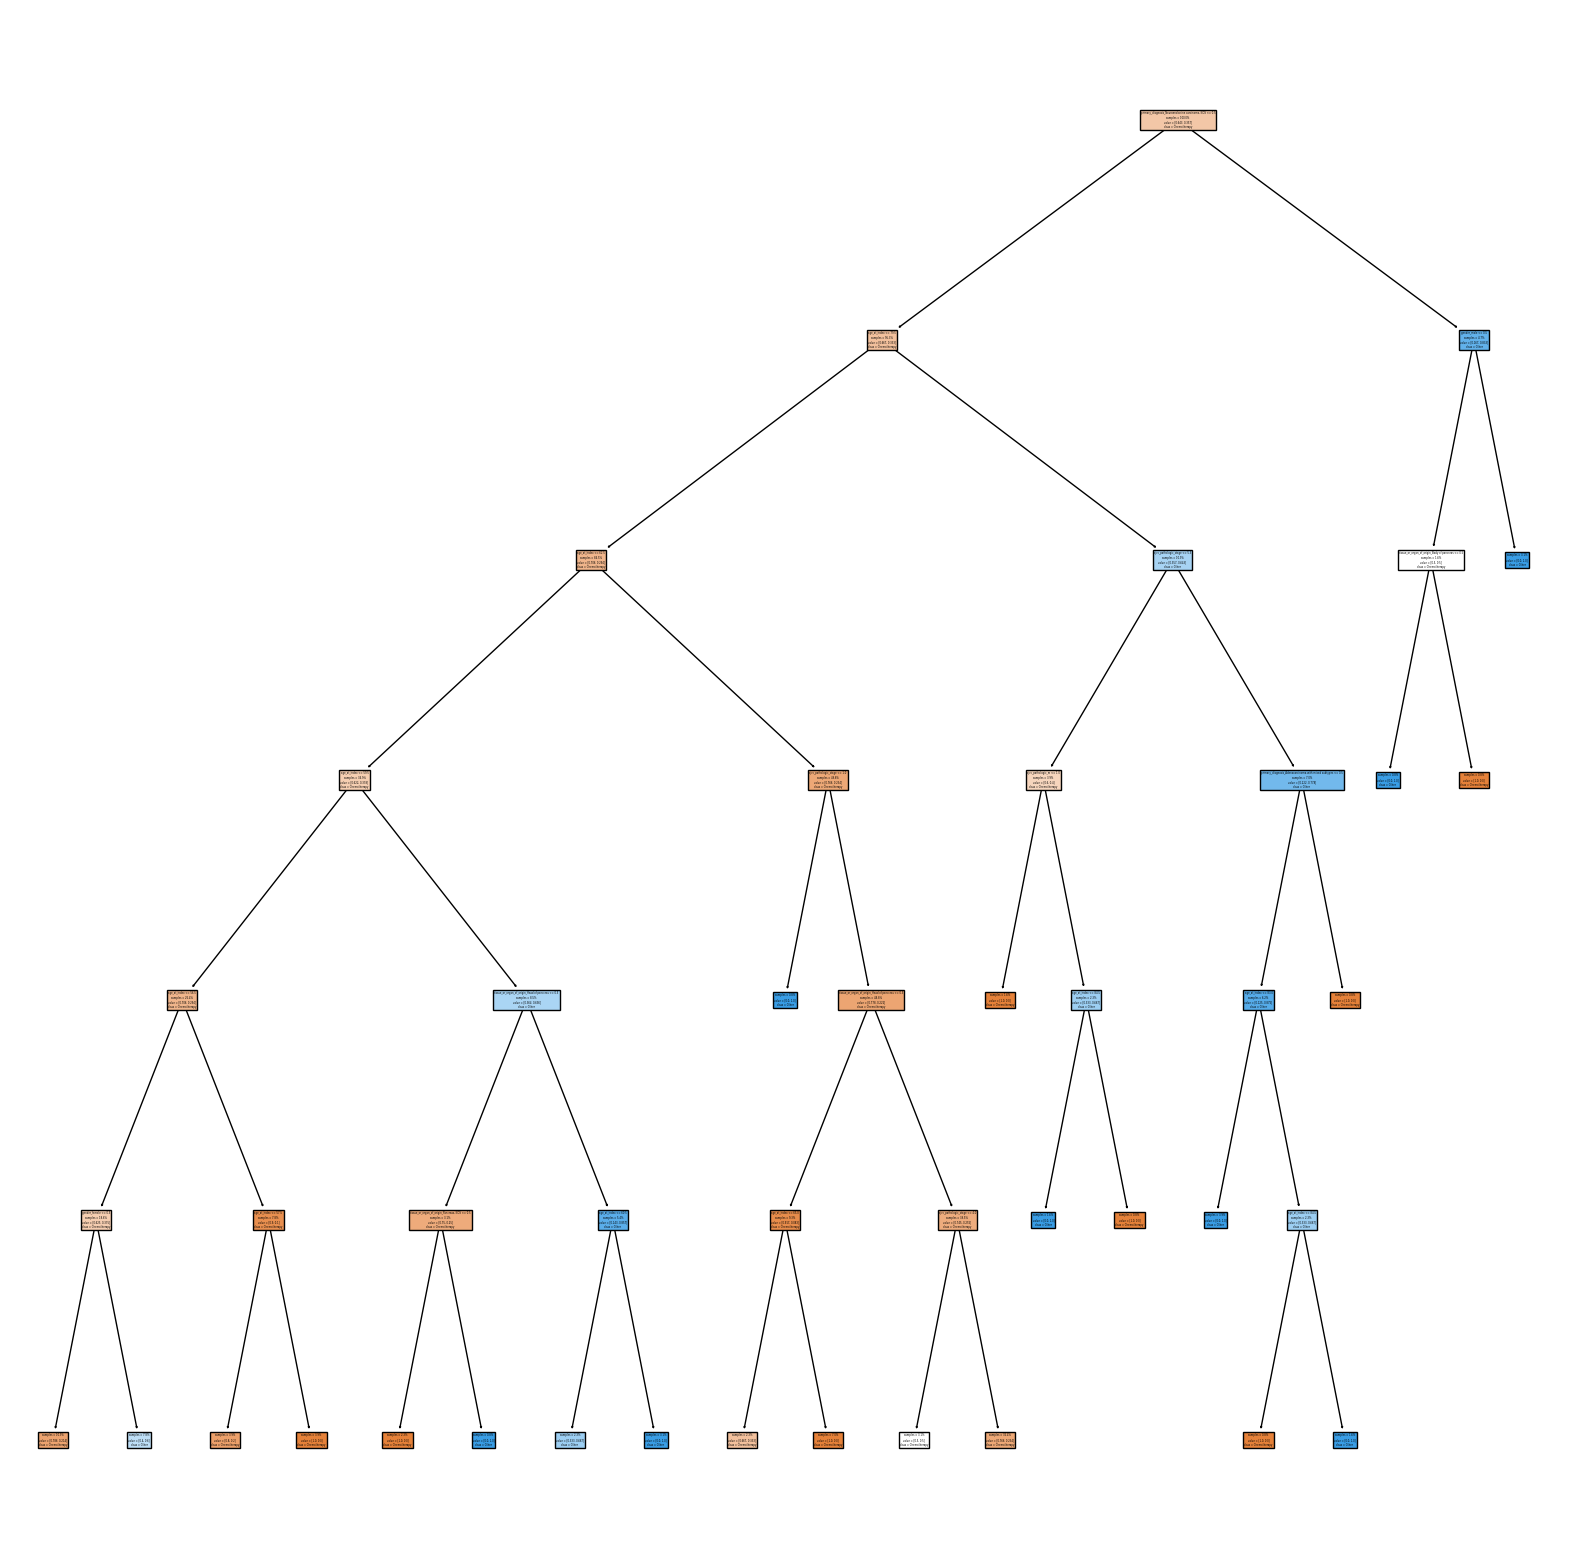

In [24]:
# 5. Get simple chart representation
dt_fig = plt.figure(figsize=(20,20))
tree.plot_tree(dt_clf,
          feature_names=X_encoded.columns,
          class_names=['Chemotherapy','Other'],
          impurity=False,
          proportion=True,
          filled=True)
plt.show()

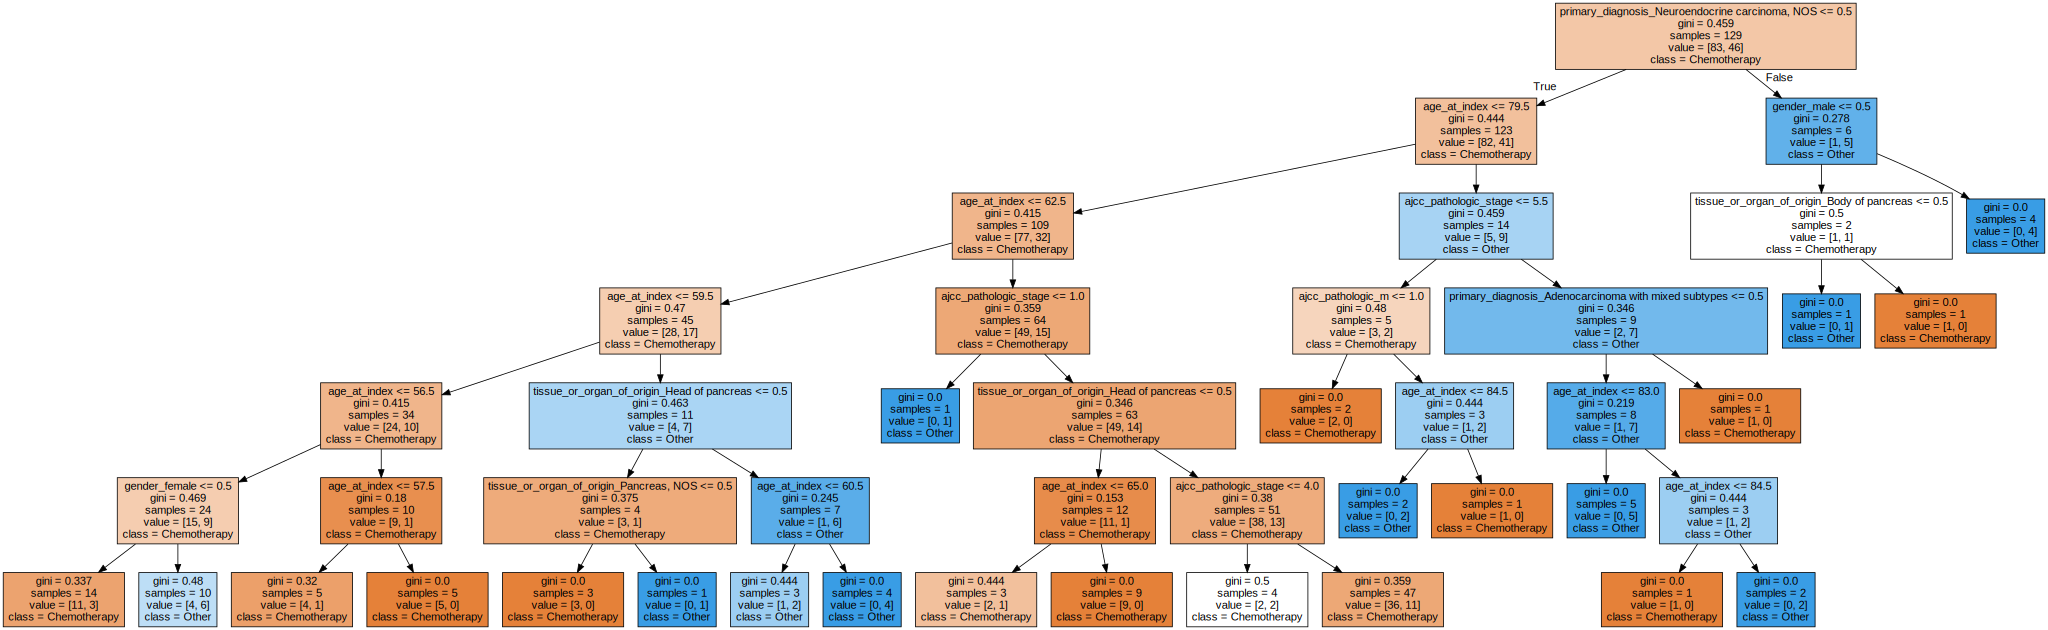

In [25]:
# 6. Visualize graph with graphviz library
import graphviz
dot_data = tree.export_graphviz(dt_clf, out_file=None, feature_names= X_encoded.columns, class_names=['Chemotherapy', 'Other'], filled=True)
graph = graphviz.Source(dot_data, format="png")
graph

## Permutation Importance

Permutation Importance is an algorithm that computes importance scores
for each of the feature variables of a dataset. The importance measures are determined by computing the sensitivity of a model to random permutations of feature values.

It measures the importance of a feature by calculating the increase in the model’s prediction error after permuting the feature.

In [26]:
# 1. Install required package
!pip install eli5
import eli5
from eli5.sklearn import PermutationImportance

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.2/216.2 kB 4.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for eli5: filename=eli5-0.13.0-py2.py3-none-any.whl size=107719 sha256=06f96ef8b7fd952781e76abdf83482351b257f8e004b804294080b2261cf9920
  Stored in directory: /root/.cache/pip/wheels/b8/58/ef/2cf4c306898c2338d51540e0922c8e0d6028e07007085c0004
Successfully built eli5


In [27]:
# 2. Get permitation importance data
perm = PermutationImportance(dt_clf, random_state=42).fit(X_test, y_test)
eli5.show_weights(perm, feature_names = X_encoded.columns.tolist())

In [28]:
# 3. Get weights to show feature importance
eli5.show_weights(dt_clf, feature_names = list(X_test.columns))

In [ ]:
# 4. Patient 3 data
eli5.show_prediction(dt_clf, X_train.iloc[2])

In [ ]:
# 5. Patient 4 data
eli5.show_prediction(dt_clf, X_train.iloc[3])

# Create a XGBClassifier model

In [ ]:
# 1. Create a XGBClassifier model
#import xgboost as xgb

#y_train[y_train == 'Other'] = 0
#y_train[y_train == 'Chemotherapy'] = 1

#y_test[y_test == 'Other'] = 0
#y_test[y_test == 'Chemotherapy'] = 1

#xgb_clf = xgb.XGBClassifier(objective="binary:logistic", max_depth=2, n_estimators=10)
#xgb_estimator = xgb_clf.fit(X_train, y_train)

In [ ]:
# 2. Predict the response for test dataset
#y_xgb_pred = xgb_clf.predict(X_test)
# TODO error al intentar obtener la precisión: https://stackoverflow.com/questions/38015181/accuracy-score-valueerror-cant-handle-mix-of-binary-and-continuous-target
#xgb_acc = metrics.accuracy_score(y_test, y_xgb_pred)
#print("XGBOOST accuracy: ", dt_acc)

In [ ]:
#xgb_explainer = shap.Explainer(xgb_clf)
#shap_values = xgb_explainer(X_encoded)

# waterfall plot for first observation
#shap.plots.waterfall(xgb_explainer.expected_value[1])

# Creating a Random Forest model and using SHAP and LIME to explain it

In [ ]:
# 1. Build a Random Forest Model
rf_clf = RandomForestClassifier(bootstrap=True)

In [ ]:
# 2. Train Random Forest Classifer
rf_clf = rf_clf.fit(X_train, y_train)

In [ ]:
# 3. Predict the response for test dataset
y_rf_pred = rf_clf.predict(X_test)

dt_acc = metrics.accuracy_score(y_test, y_rf_pred)
print("Random Forrest Tree accuracy: ", dt_acc)

Random Forrest Tree accuracy:  0.6071428571428571


In [ ]:
# 4. Show Classification Report
print(metrics.classification_report(y_rf_pred, y_test))

              precision    recall  f1-score   support

Chemotherapy       0.79      0.64      0.71        42
       Other       0.32      0.50      0.39        14

    accuracy                           0.61        56
   macro avg       0.56      0.57      0.55        56
weighted avg       0.68      0.61      0.63        56



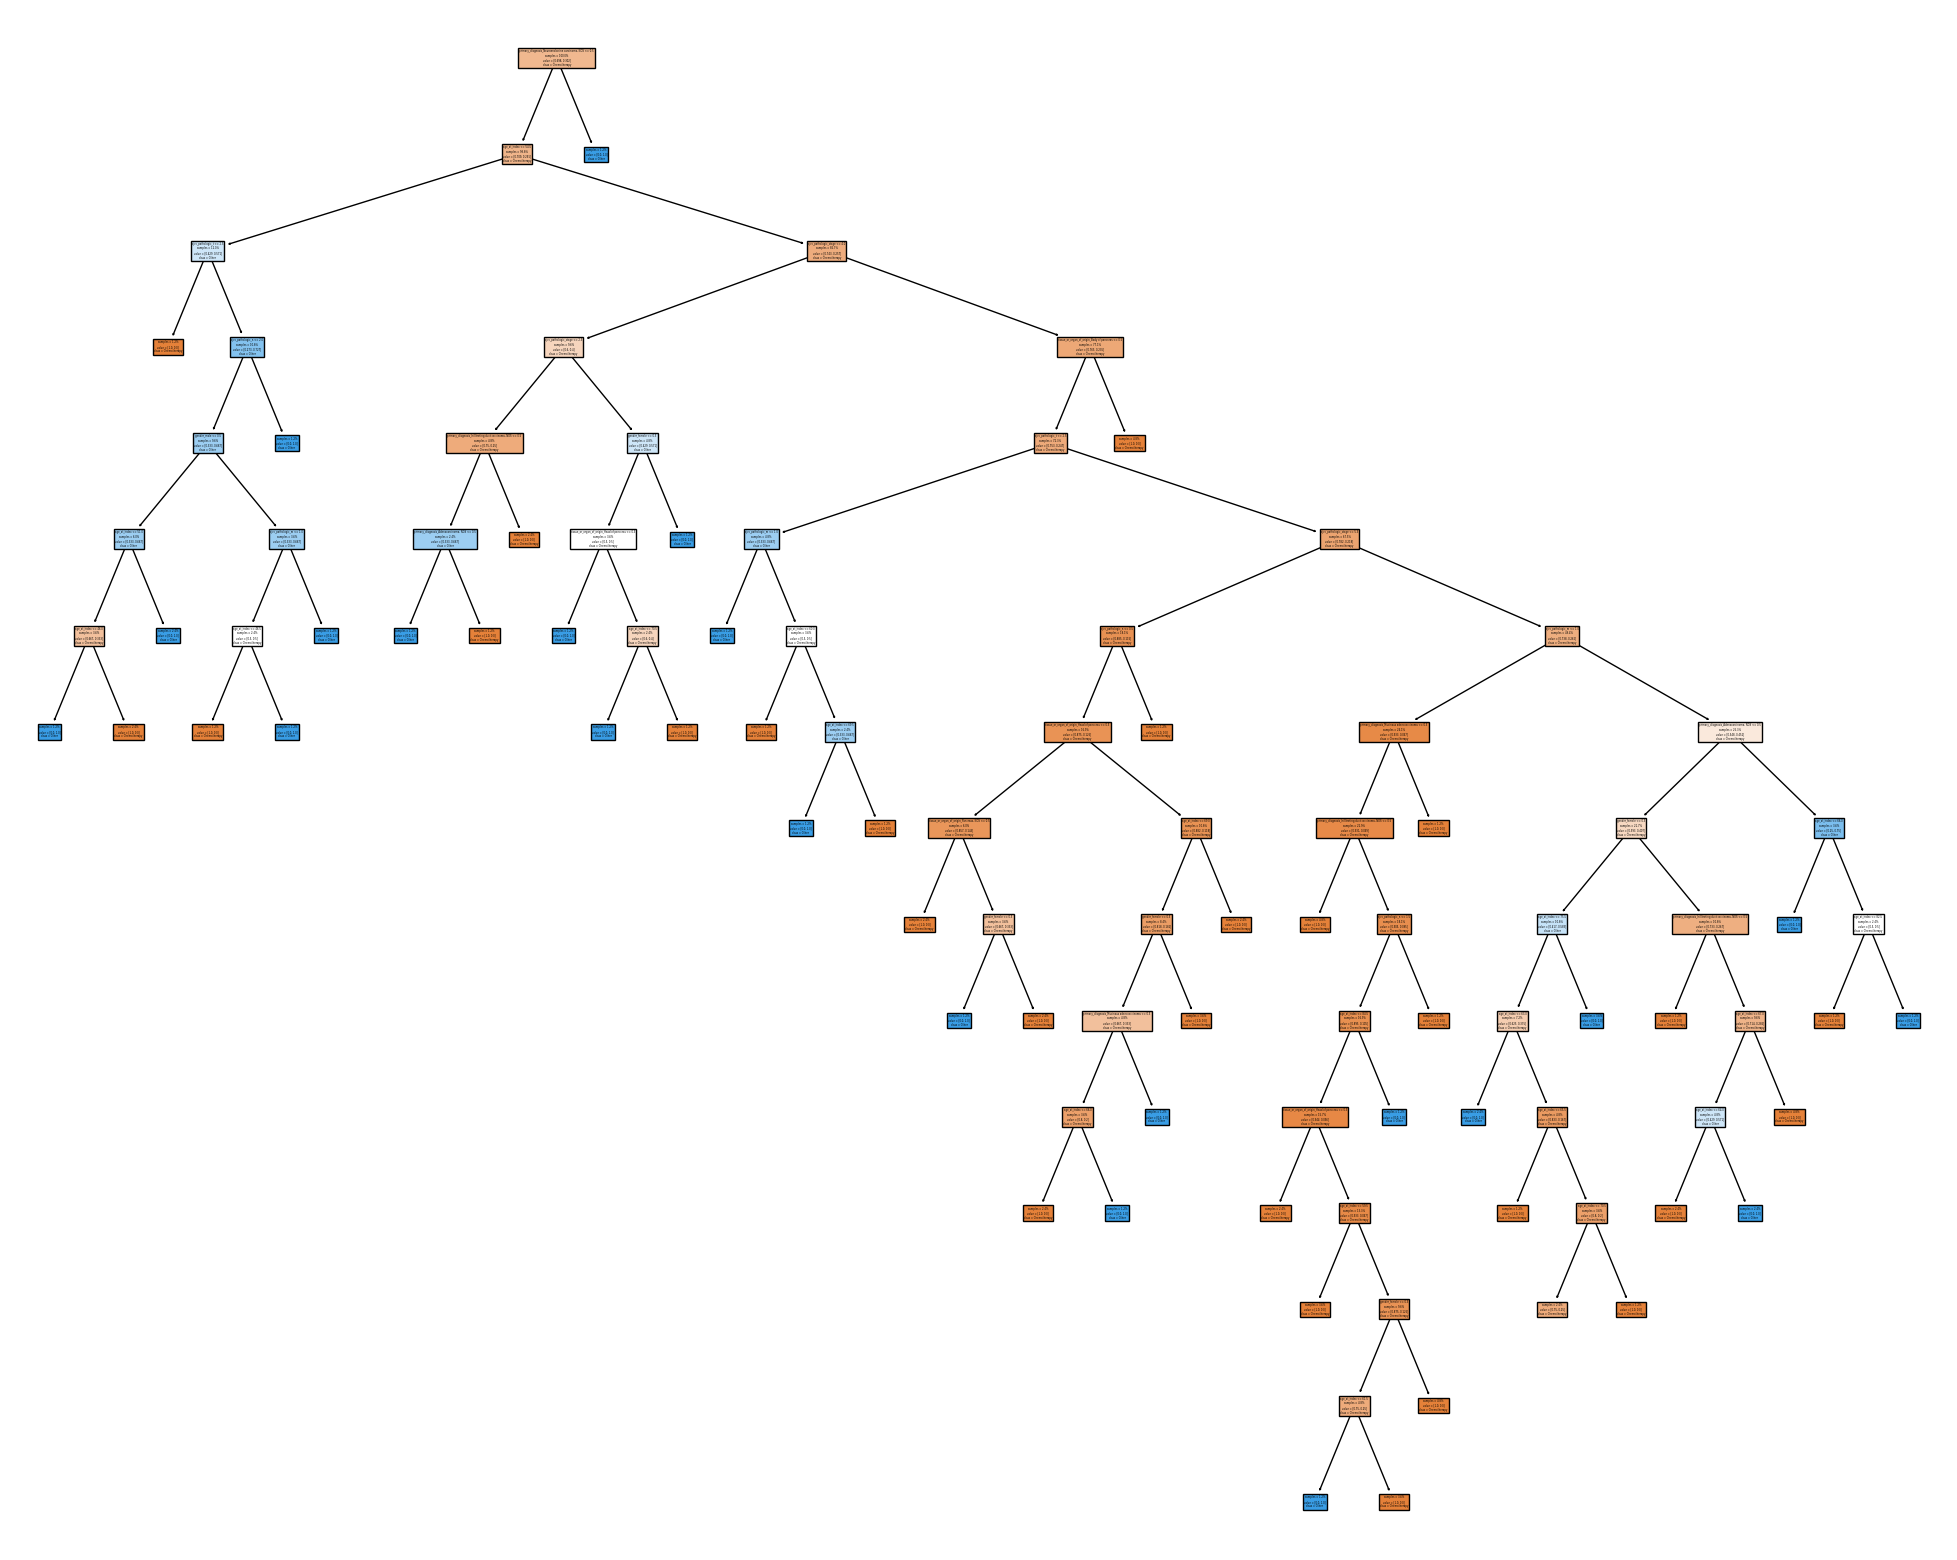

In [ ]:
# 5. Visualize the decision tree
rf_fig = plt.figure(figsize=((25,20)))
tree.plot_tree(rf_clf.estimators_[0],
            feature_names = X_encoded.columns,
            class_names=['Chemotherapy','Other'],
            impurity=False,
            proportion=True,
            filled=True)
rf_fig.savefig('rf_tree.png')
plt.show()

The tree representation that we get from the Random Forest makes it difficult to follow the decision the algorithm takes at every node.

Integrating an explainability layer into your machine learning models can make them more understandable and trustworthy.

## Exaplainability with SHAP

In [ ]:
!pip install shap
import shap


Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [ ]:
# Explain the model's predictions using SHAP
explainerShap = shap.TreeExplainer(rf_clf)

# Compute shap_values for X_test
shap_values = explainerShap.shap_values(X_test)

**Pacient 3**
Get the data from patient 3

In [ ]:
paciente3 = X_encoded.loc[[2]]
paciente3

age_at_index  ajcc_pathologic_m  ajcc_pathologic_n  ajcc_pathologic_stage  \
2            58                  1                  0                      8   

   ajcc_pathologic_t  gender_female  gender_male  \
2                  3              1            0   

   primary_diagnosis_Adenocarcinoma with mixed subtypes  \
2                                                  0      

   primary_diagnosis_Adenocarcinoma, NOS  \
2                                      0   

   primary_diagnosis_Carcinoma, undifferentiated, NOS  \
2                                                  0    

   primary_diagnosis_Infiltrating duct carcinoma, NOS  \
2                                                  1    

   primary_diagnosis_Mucinous adenocarcinoma  \
2                                          0   

   primary_diagnosis_Neuroendocrine carcinoma, NOS  \
2                                                0   

   tissue_or_organ_of_origin_Body of pancreas  \
2                                           0   

   tissue_or_organ_of_origin_Head of pancreas  \
2                                           0   

   tissue_or_organ_of_origin_Overlapping lesion of pancreas  \
2                                                  0          

   tissue_or_organ_of_origin_Pancreas, NOS  \
2                                        0   

   tissue_or_organ_of_origin_Tail of pancreas  
2                                           1

In [ ]:
y[2]

'Other'

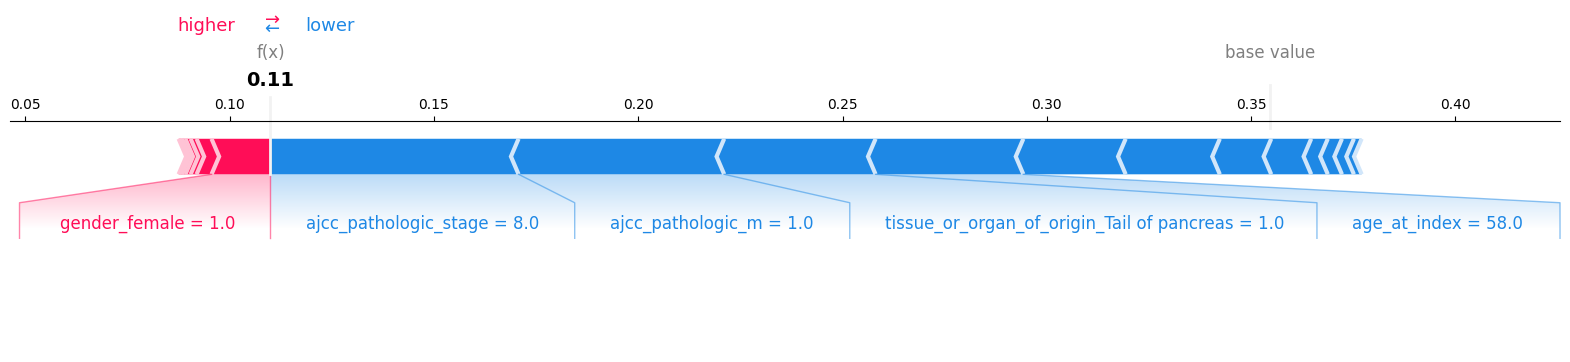

In [ ]:
shap.initjs()
paciente3_shap_values = explainerShap.shap_values(paciente3)

shap.force_plot(explainerShap.expected_value[1], paciente3_shap_values[1], paciente3, matplotlib = True, show=False)

In [ ]:
#plt.savefig("shap_paciente3.png")
plt.close()

Paciente 4

In [ ]:
paciente4 = X_encoded.loc[[3]]
paciente4

age_at_index  ajcc_pathologic_m  ajcc_pathologic_n  ajcc_pathologic_stage  \
3            66                  0                  0                      5   

   ajcc_pathologic_t  gender_female  gender_male  \
3                  3              1            0   

   primary_diagnosis_Adenocarcinoma with mixed subtypes  \
3                                                  0      

   primary_diagnosis_Adenocarcinoma, NOS  \
3                                      0   

   primary_diagnosis_Carcinoma, undifferentiated, NOS  \
3                                                  0    

   primary_diagnosis_Infiltrating duct carcinoma, NOS  \
3                                                  1    

   primary_diagnosis_Mucinous adenocarcinoma  \
3                                          0   

   primary_diagnosis_Neuroendocrine carcinoma, NOS  \
3                                                0   

   tissue_or_organ_of_origin_Body of pancreas  \
3                                           0   

   tissue_or_organ_of_origin_Head of pancreas  \
3                                           0   

   tissue_or_organ_of_origin_Overlapping lesion of pancreas  \
3                                                  0          

   tissue_or_organ_of_origin_Pancreas, NOS  \
3                                        1   

   tissue_or_organ_of_origin_Tail of pancreas  
3                                           0

In [ ]:
y[3]

'Chemotherapy'

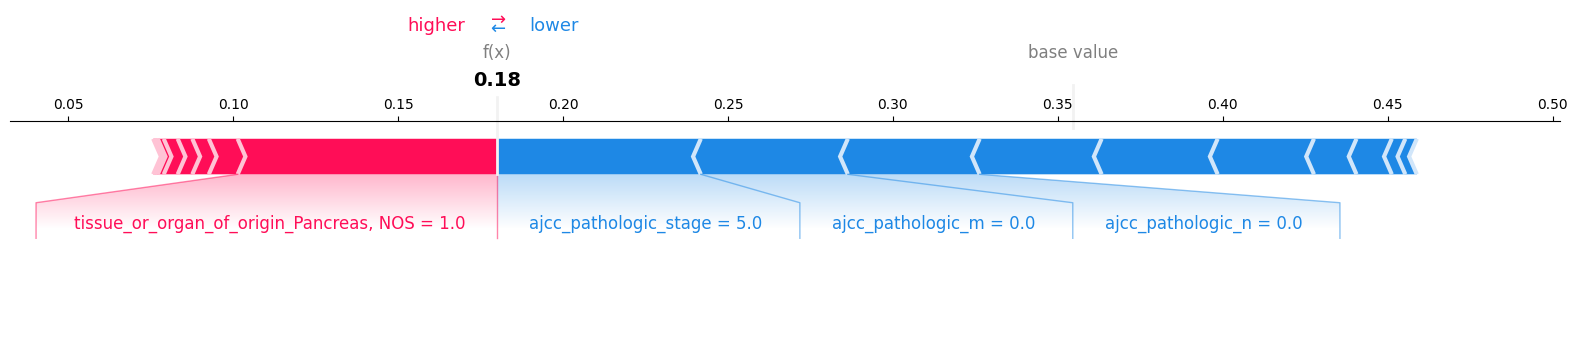

In [ ]:
paciente4_shap_values = explainerShap.shap_values(paciente4)

shap.force_plot(explainerShap.expected_value[1], paciente4_shap_values[1], paciente4, matplotlib = True, show=False)

Feature values in pink cause to increase the prediction. Size of the bar shows the magnitude of the feature's effect.

Feature values in blue causse to decrease the prediction. Sum of all feature SHAP values explain why model prediction was different from the baseline.

In [ ]:
#plt.savefig("shap_paciente4.png")
plt.close()

Summary plot will give us the variable importance plot. Features with high predicting power are shown at the top and the ones with low predicting powers are shown at the bottom.

We could see the contribution of each data into the prediction probability. The redder the colour, the higher the value and vice versa. Also, when the value is on the positive side, it contributes to the class 0 prediction result probability and vice versa.

Variable Importance Plot - Global Interpretation


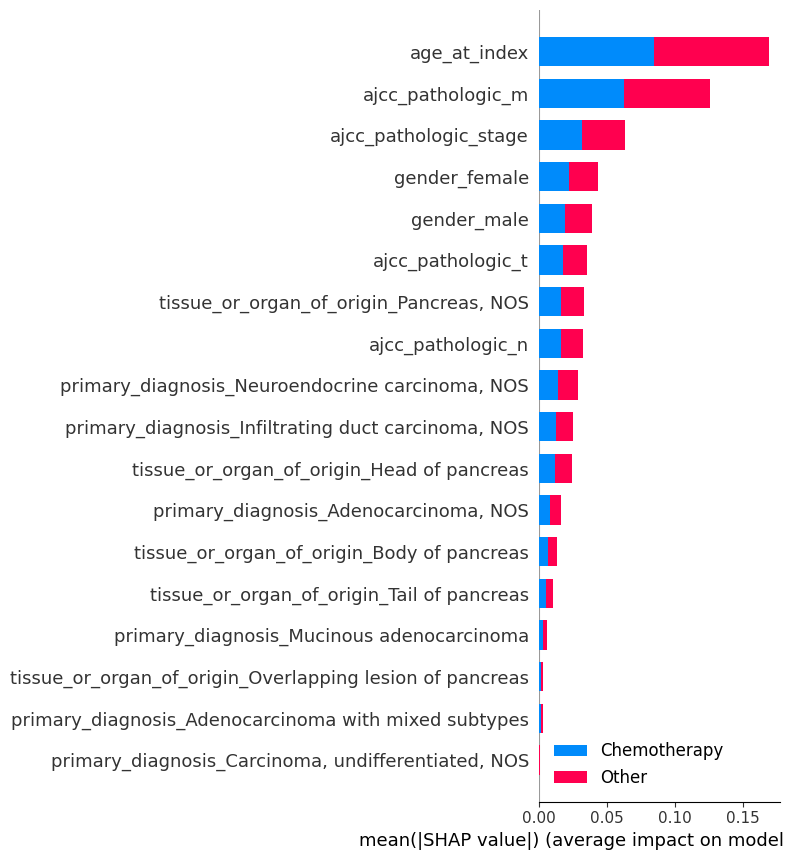

In [ ]:
print("Variable Importance Plot - Global Interpretation")
shap.summary_plot(shap_values, X_test, plot_type='bar', class_names=['Chemotherapy','Other'])

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


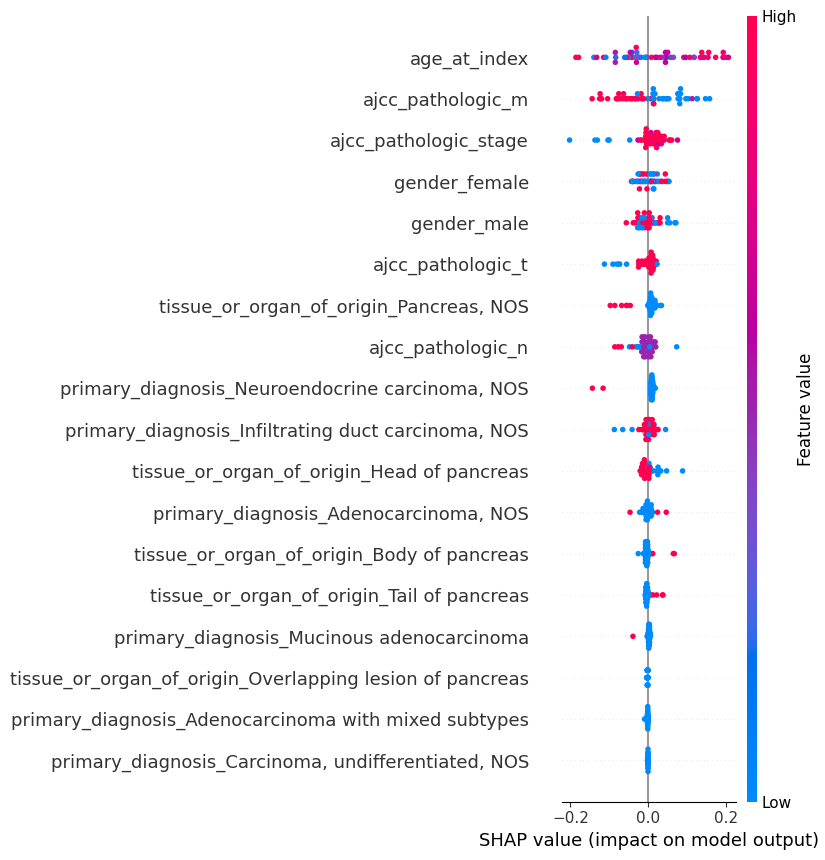

In [ ]:
# Summary plot in an individual sample
shap.summary_plot(shap_values[0], X_test)

The **partial dependence plot** is a global method: The method considers all instances and gives a statement about the global relationship of a feature with the predicted outcome.

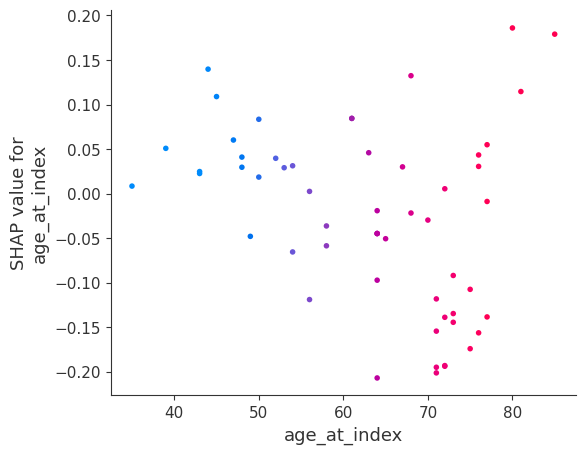

In [ ]:
shap.dependence_plot('age_at_index', shap_values[1], X_test, interaction_index='age_at_index')

A continuación incluimos un gráfico de decisión:

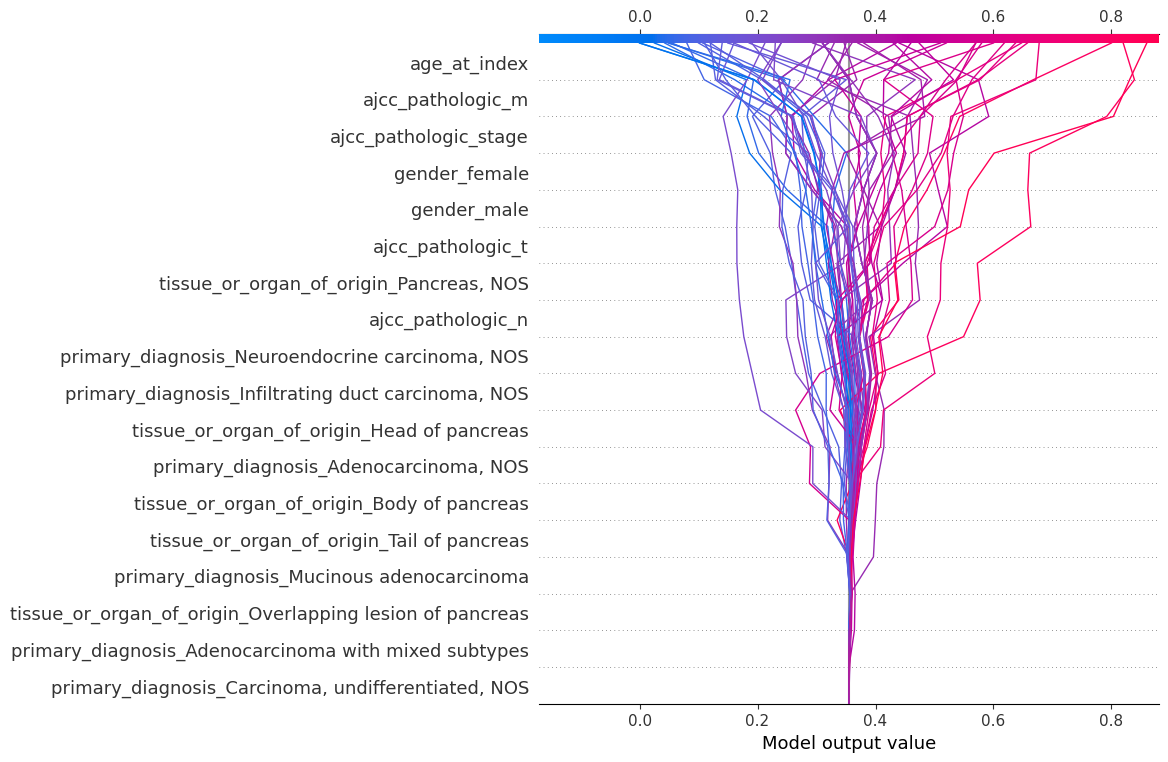

In [ ]:
i=1
shap.decision_plot(explainerShap.expected_value[i], shap_values[i], feature_names = list(X_encoded.columns))

Y finalmente un gráfico de fuerzas:

In [ ]:
shap.initjs()
i = 1
shap.force_plot(explainerShap.expected_value[i], shap_values[i], feature_names = list(X_encoded.columns))

## Explainability with LIME

LIME (Local Interpretable Model-Agnostic Explanations) is a method for explaining the predictions of any classifier and regressor (model agnostic).

In [ ]:
# Install SHAP (SHapley Additive exPlanations).
!pip install lime

# Import required libraries
from lime.lime_tabular import LimeTabularExplainer

X does not have valid feature names, but RandomForestClassifier was fitted with feature names


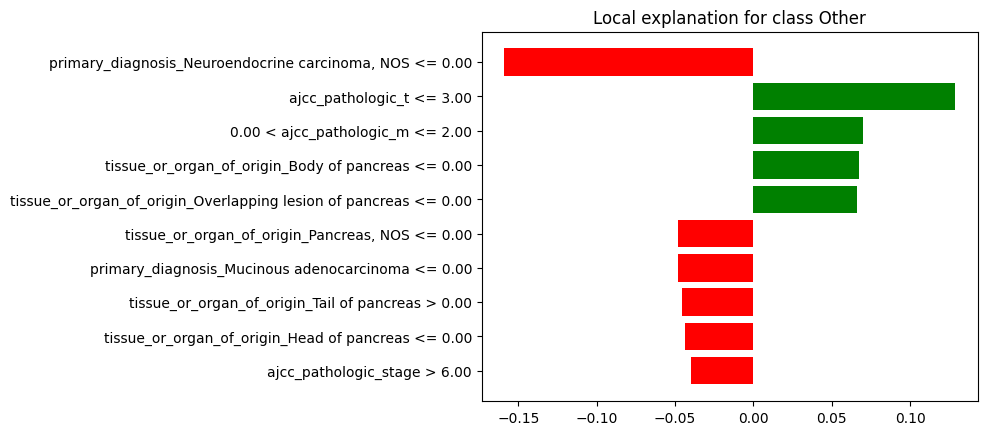

In [ ]:
# XAI with LIME (Local Interpretable Model-agnostic Explanations)
explainerLime = LimeTabularExplainer(X_encoded.values, feature_names=X_encoded.columns, class_names = ['Chemotherapy', 'Other'], discretize_continuous=True)

# Patient 3 LIME explanation
expPatient3 = explainerLime.explain_instance(X_encoded.values[2], rf_clf.predict_proba, num_features=10, top_labels=5)
expPatient3.show_in_notebook(show_all=True)
expPatient3.as_pyplot_figure()


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


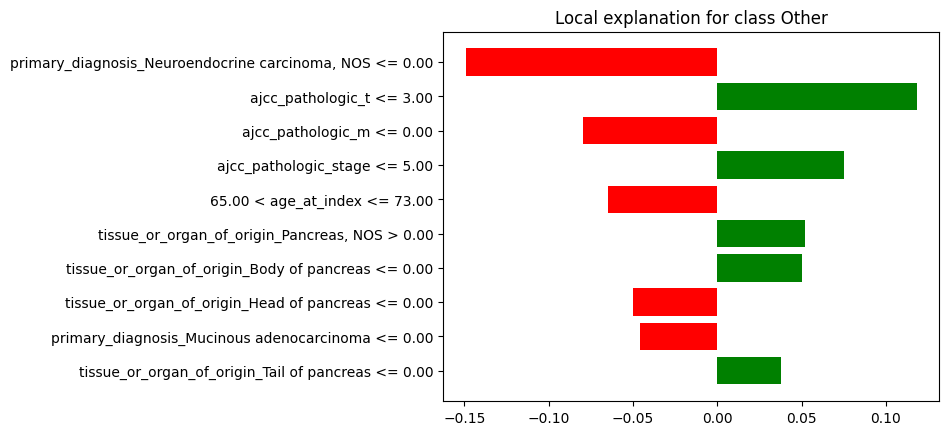

In [ ]:
# Patient 4 LIME explanation
expPatient4 = explainerLime.explain_instance(X_encoded.values[3], rf_clf.predict_proba, num_features=10, top_labels=3)
expPatient4.show_in_notebook(show_all=True)
expPatient4.as_pyplot_figure()

# Create a K-nearest neighbors classifier model

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
knn_clf = KNeighborsClassifier(n_neighbors=1)

knn_clf = knn_clf.fit(X_train, y_train)

In [ ]:
knn_pred_labels = knn_clf.predict(X_test)

In [ ]:
# Basic info about the model
print('---------------------------------------------------------')
print('****************** KNN Classification ******************')
print('Classes: ', knn_clf.classes_)
print('Effective Metric: ', knn_clf.effective_metric_)
print('Effective Metric Params: ', knn_clf.effective_metric_params_)
print('No. of Samples Fit: ', knn_clf.n_samples_fit_)
print('Outputs 2D: ', knn_clf.outputs_2d_)
print('--------------------------------------------------------')
print("")

---------------------------------------------------------
****************** KNN Classification ******************
Classes:  ['Chemotherapy' 'Other']
Effective Metric:  euclidean
Effective Metric Params:  {}
No. of Samples Fit:  129
Outputs 2D:  False
--------------------------------------------------------



In [ ]:
print('*************** Evaluation on Test Data ***************')
knn_score = knn_clf.score(X_test, y_test)
print('Accuracy Score: ', knn_score)
# Look at classification report to evaluate the model
print(metrics.classification_report(y_test, knn_pred_labels))
#print('--------------------------------------------------------')
print("")

*************** Evaluation on Test Data ***************
Accuracy Score:  0.5892857142857143
              precision    recall  f1-score   support

Chemotherapy       0.66      0.68      0.67        34
       Other       0.48      0.45      0.47        22

    accuracy                           0.59        56
   macro avg       0.57      0.57      0.57        56
weighted avg       0.59      0.59      0.59        56




# Misceláneo

We include below some information extracted using nice python libraries:


1. Sweetviz
2. Explainer Dashboard (Not yet)
3. Lazy Predict




## Sweetviz

In [ ]:
!pip install sweetviz

In [ ]:
import sweetviz

report = sweetviz.analyze(dataset)

                                             |          | [  0%]   00:00 -> (? left)


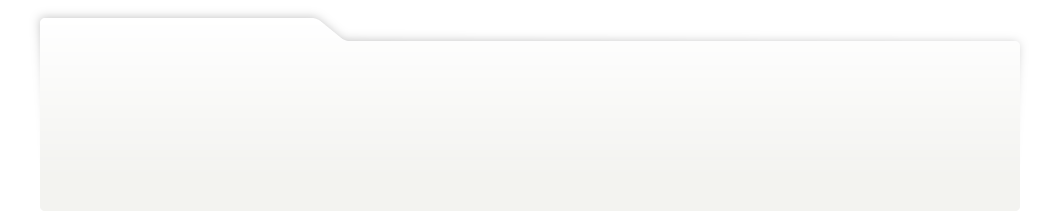
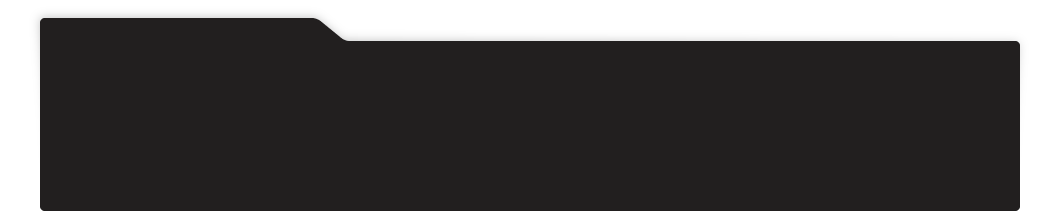
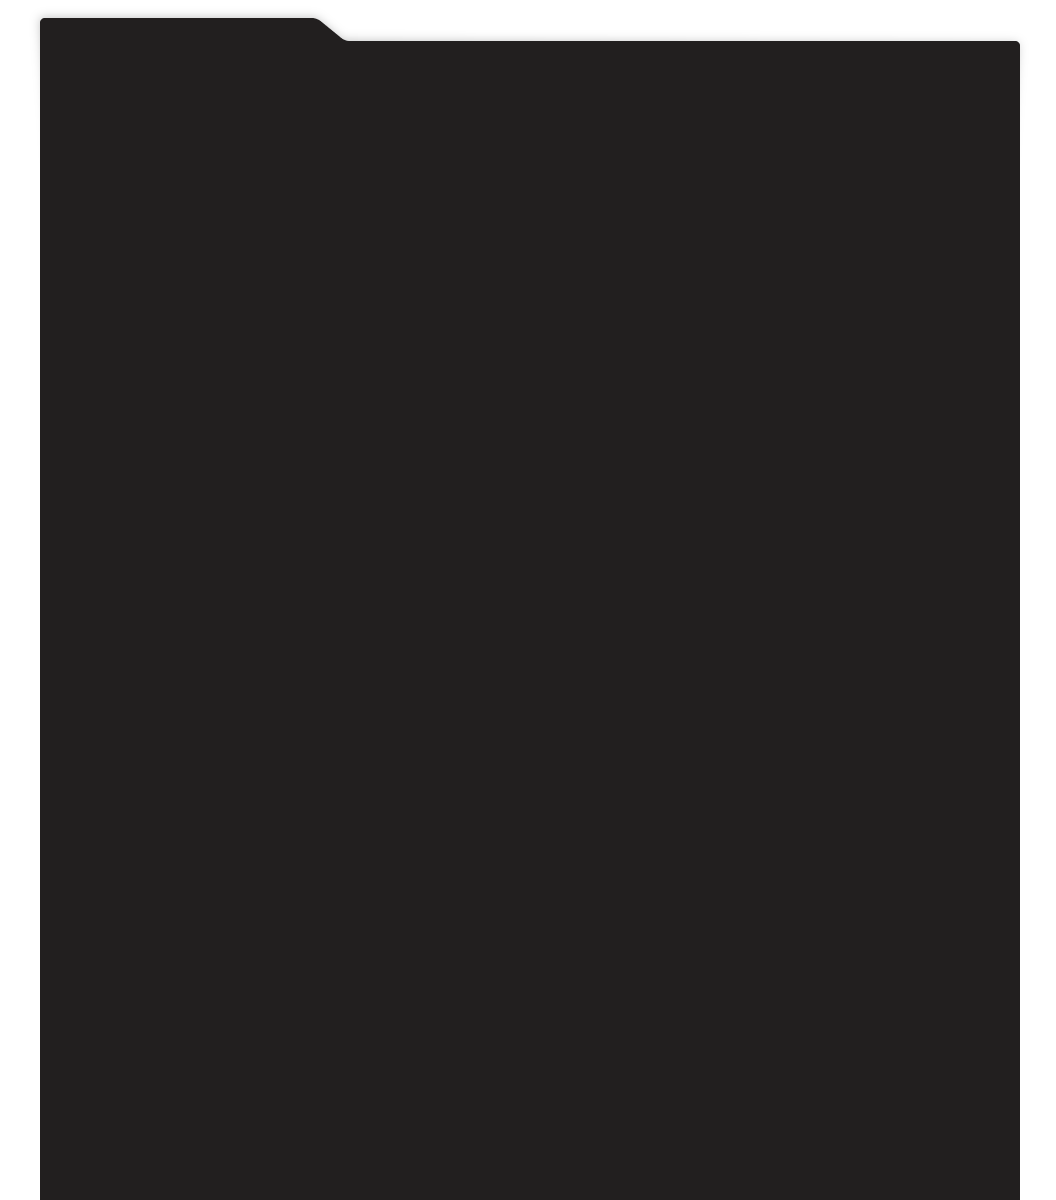
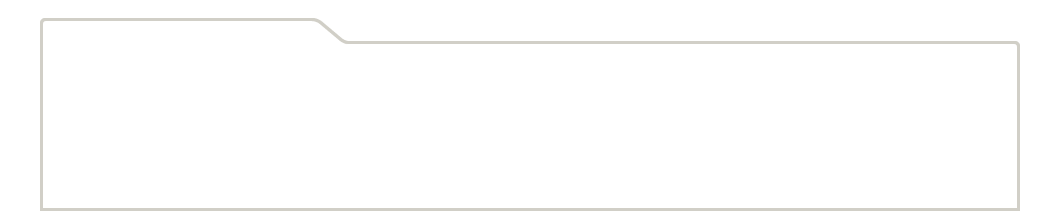
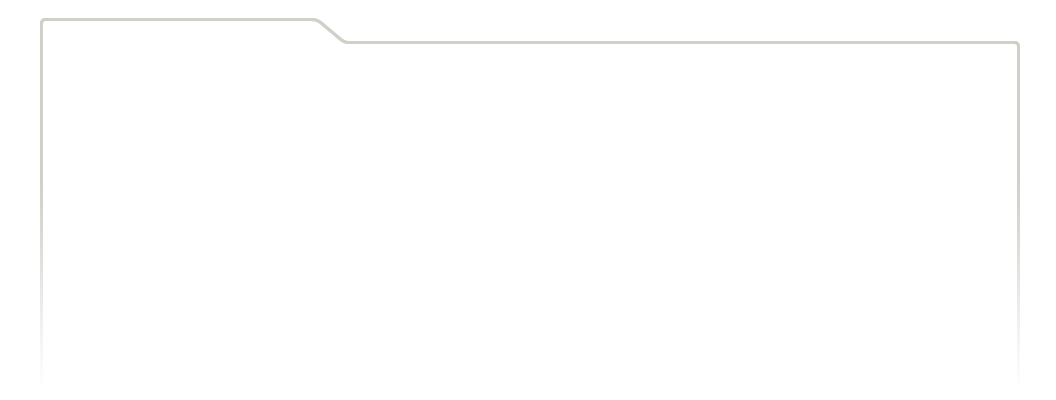
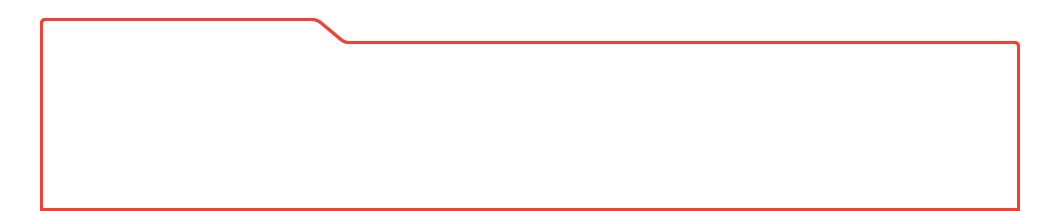
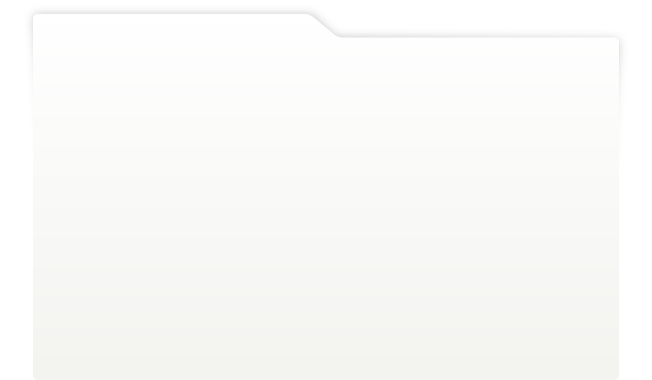
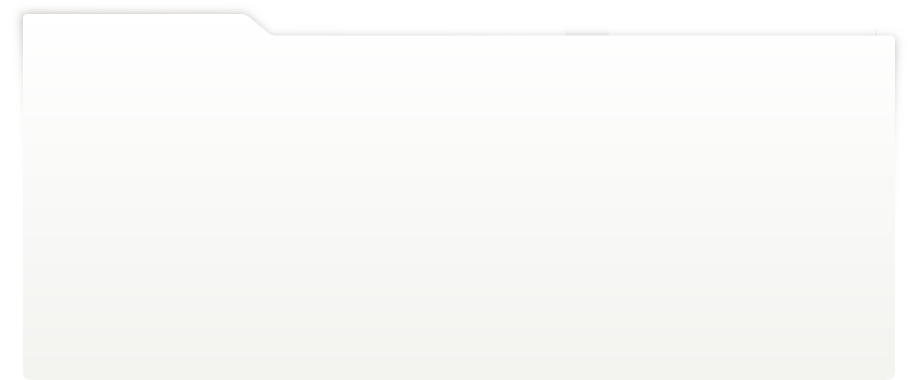
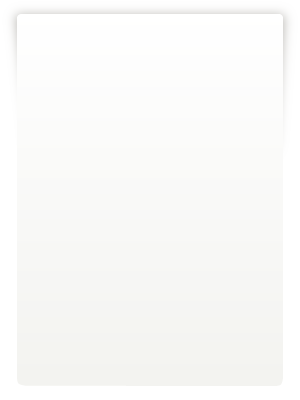
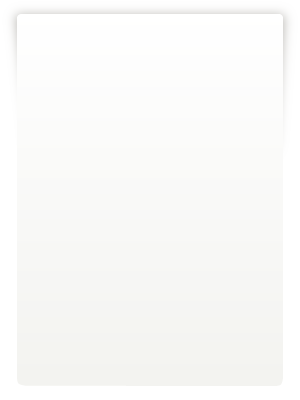
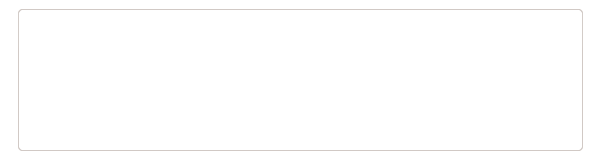
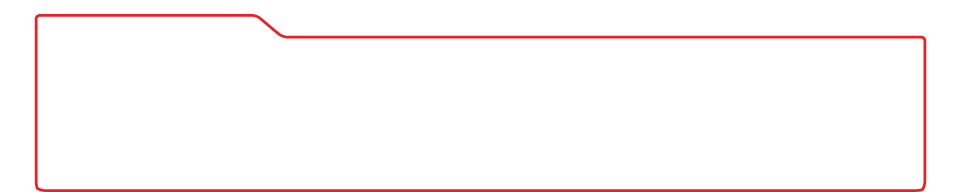
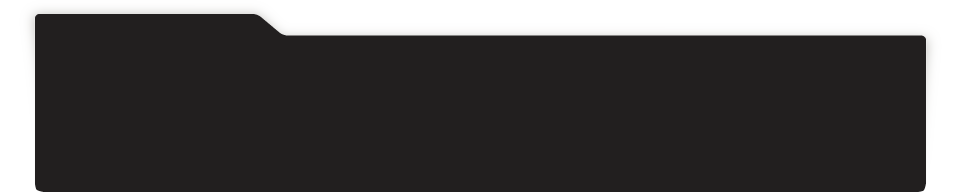
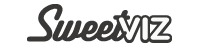
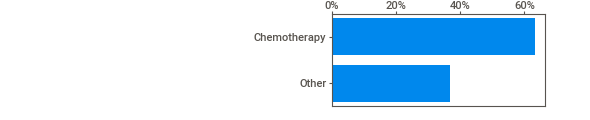
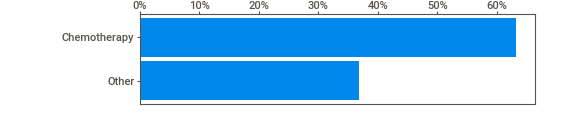
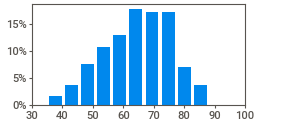
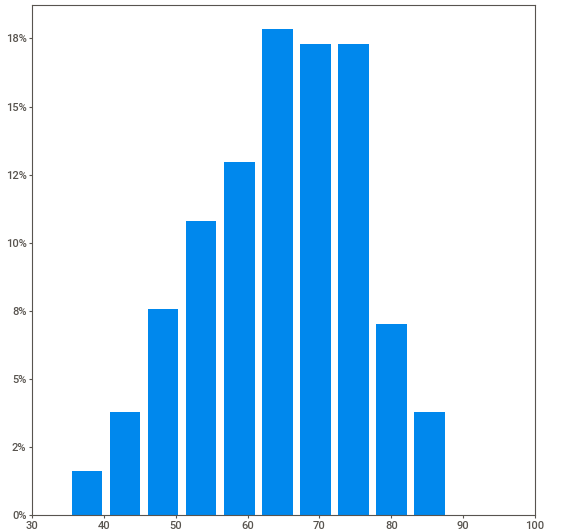
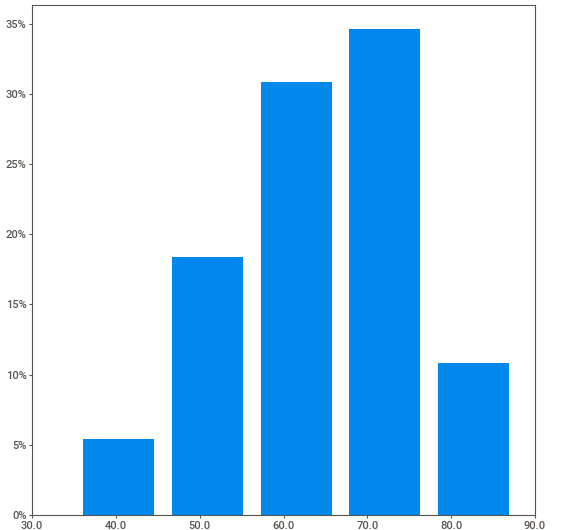
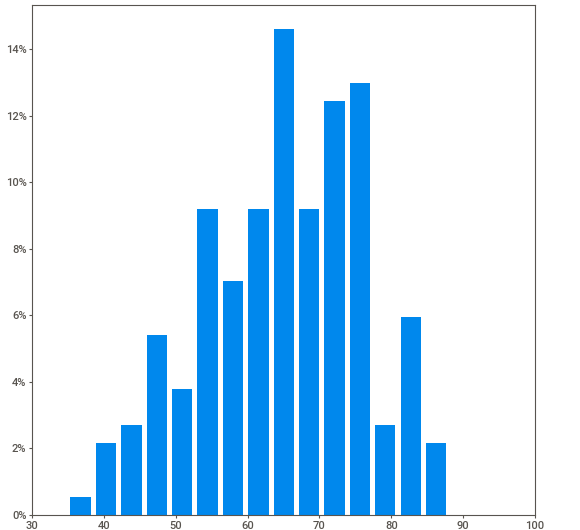
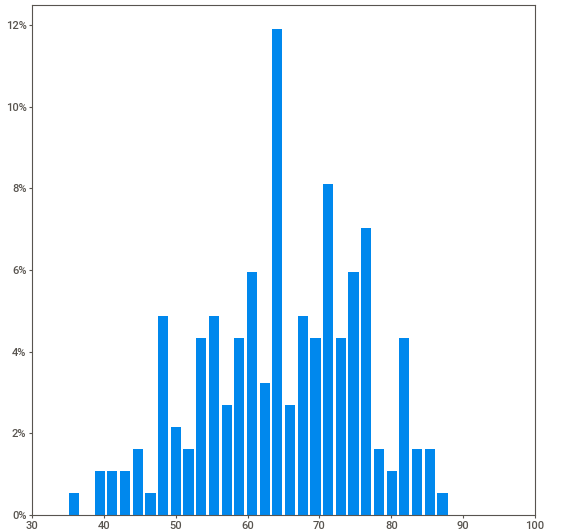
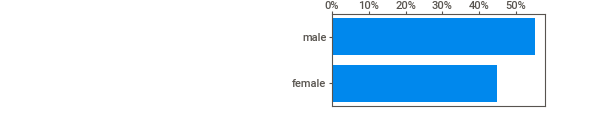
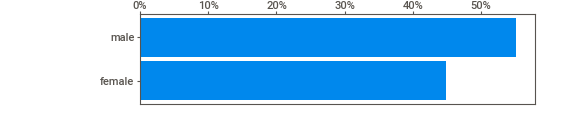
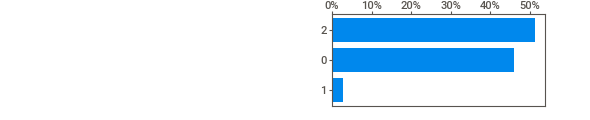
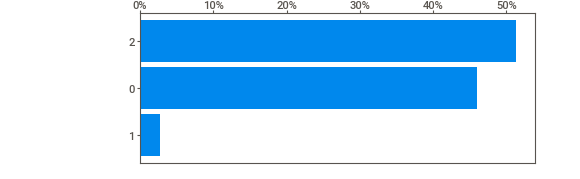
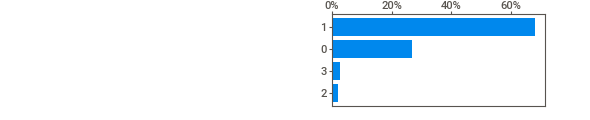
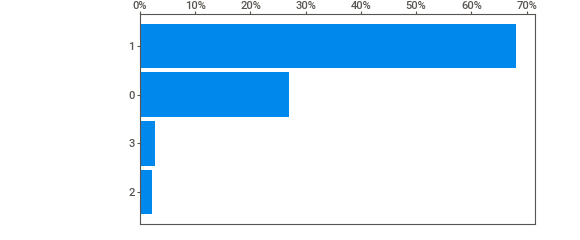
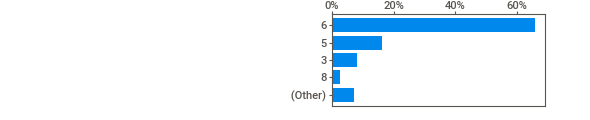
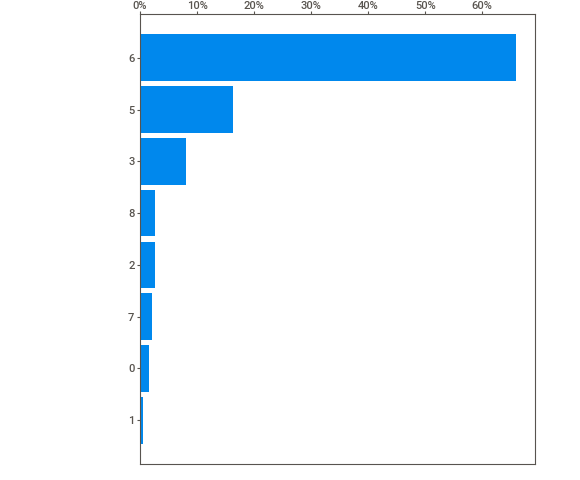
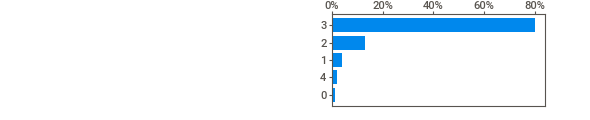
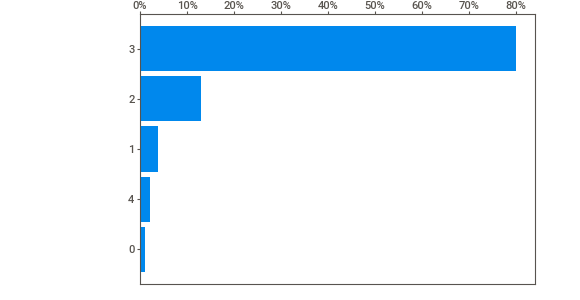
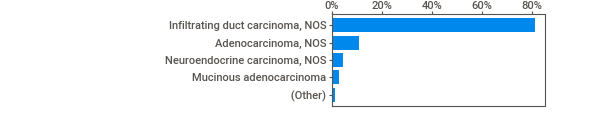
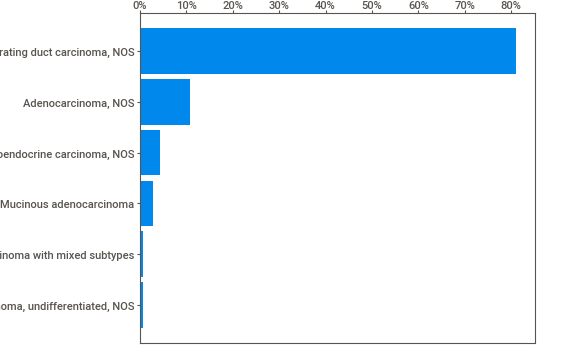
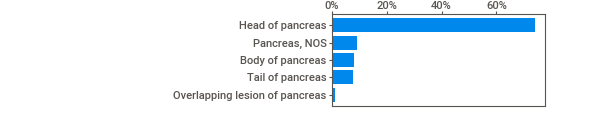
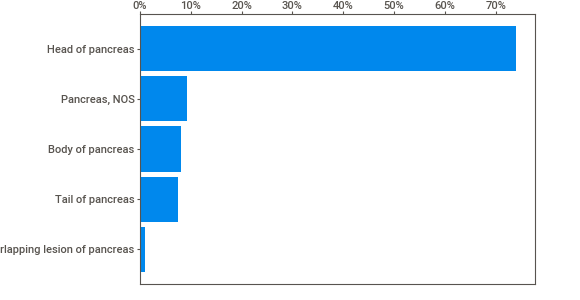
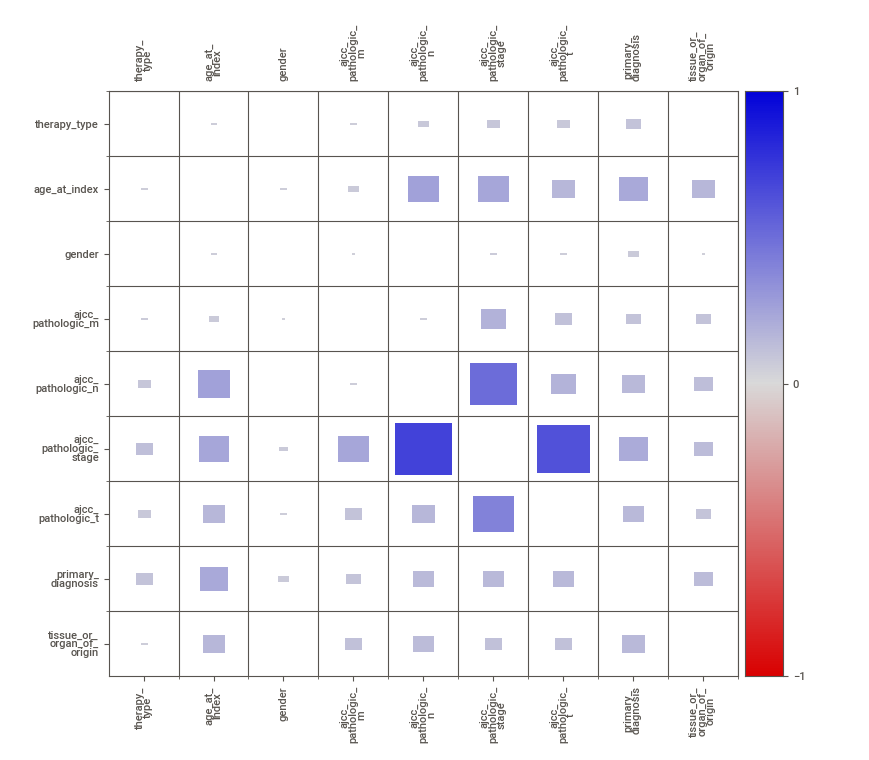
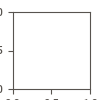

In [ ]:
#To save the HTML format of the report, use this:
#report.show_html()

#To view the report inside a Jupyter Notebook, use this:
report.show_notebook()

# Lazy Predict

Lazy Predict ranks the machine learning models that will most likely be suitable.

In [ ]:
!pip install lazypredict

In [ ]:
import lazypredict
from lazypredict.Supervised import LazyClassifier
lc_clf = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=None)

#Training the models
models,predictions = lc_clf.fit(X_train, X_test, y_train, y_test)

# Printing the output
models

100%|██████████| 29/29 [00:01<00:00, 27.72it/s]

[LightGBM] [Info] Number of positive: 46, number of negative: 83
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000213 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 62
[LightGBM] [Info] Number of data points in the train set: 129, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.356589 -> initscore=-0.590199
[LightGBM] [Info] Start training from score -0.590199
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


Accuracy  Balanced Accuracy ROC AUC  F1 Score  \
Model                                                                          
NearestCentroid                    0.66               0.63    None      0.66   
NuSVC                              0.70               0.63    None      0.66   
DecisionTreeClassifier             0.64               0.62    None      0.64   
RandomForestClassifier             0.66               0.62    None      0.64   
AdaBoostClassifier                 0.64               0.61    None      0.63   
LogisticRegression                 0.68               0.61    None      0.63   
LGBMClassifier                     0.66               0.60    None      0.63   
ExtraTreeClassifier                0.61               0.60    None      0.61   
SGDClassifier                      0.62               0.59    None      0.62   
LinearSVC                          0.66               0.58    None      0.60   
LinearDiscriminantAnalysis         0.66               0.58    None      0.60   
BaggingClassifier                  0.61               0.58    None      0.60   
BernoulliNB                        0.66               0.58    None      0.59   
RidgeClassifierCV                  0.66               0.58    None      0.59   
RidgeClassifier                    0.64               0.56    None      0.57   
KNeighborsClassifier               0.61               0.56    None      0.58   
SVC                                0.64               0.55    None      0.53   
ExtraTreesClassifier               0.55               0.51    None      0.54   
QuadraticDiscriminantAnalysis      0.61               0.50    None      0.46   
GaussianNB                         0.39               0.50    None      0.22   
DummyClassifier                    0.61               0.50    None      0.46   
CalibratedClassifierCV             0.61               0.50    None      0.46   
LabelSpreading                     0.52               0.49    None      0.52   
LabelPropagation                   0.52               0.49    None      0.52   
PassiveAggressiveClassifier        0.48               0.48    None      0.49   
Perceptron                         0.45               0.42    None      0.44   

                               Time Taken  
Model                                      
NearestCentroid                      0.02  
NuSVC                                0.02  
DecisionTreeClassifier               0.01  
RandomForestClassifier               0.18  
AdaBoostClassifier                   0.12  
LogisticRegression                   0.02  
LGBMClassifier                       0.08  
ExtraTreeClassifier                  0.01  
SGDClassifier                        0.02  
LinearSVC                            0.05  
LinearDiscriminantAnalysis           0.02  
BaggingClassifier                    0.04  
BernoulliNB                          0.02  
RidgeClassifierCV                    0.02  
RidgeClassifier                      0.02  
KNeighborsClassifier                 0.02  
SVC                                  0.02  
ExtraTreesClassifier                 0.14  
QuadraticDiscriminantAnalysis        0.01  
GaussianNB                           0.02  
DummyClassifier                      0.01  
CalibratedClassifierCV               0.07  
LabelSpreading                       0.02  
LabelPropagation                     0.02  
PassiveAggressiveClassifier          0.02  
Perceptron                           0.01

# FLAML

FLAML allows us to compare different machine-learning models and helps us tune the hyperparameters and select the best model.

In [ ]:
pip install flaml

In [ ]:
from flaml import AutoML

In [ ]:
automl = AutoML()

# Specify automl goal and constraint
automl_settings = {
    "time_budget": 1,  # in seconds
    "metric": 'accuracy',
    "task": 'classification',
    "log_file_name": "iris.log",
    "estimator_list": ['rf', 'xgboost', 'extra_tree', 'xgb_limitdepth', 'lrl1']  # list of ML learners
}

# Train with labeled input data
automl.fit(X_train=X_train, y_train=y_train, **automl_settings)

[flaml.automl.logger: 09-04 23:01:48] {1679} INFO - task = classification
[flaml.automl.logger: 09-04 23:01:48] {1690} INFO - Evaluation method: cv
[flaml.automl.logger: 09-04 23:01:48] {1788} INFO - Minimizing error metric: 1-accuracy
[flaml.automl.logger: 09-04 23:01:48] {1900} INFO - List of ML learners in AutoML Run: ['rf', 'xgboost', 'extra_tree', 'xgb_limitdepth', 'lrl1']
[flaml.automl.logger: 09-04 23:01:48] {2218} INFO - iteration 0, current learner rf
[flaml.automl.logger: 09-04 23:01:48] {2344} INFO - Estimated sufficient time budget=3233s. Estimated necessary time budget=37s.
[flaml.automl.logger: 09-04 23:01:48] {2391} INFO -  at 0.4s,	estimator rf's best error=0.3954,	best estimator rf's best error=0.3954
[flaml.automl.logger: 09-04 23:01:48] {2218} INFO - iteration 1, current learner xgboost


`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[flaml.automl.logger: 09-04 23:01:49] {2391} INFO -  at 0.8s,	estimator xgboost's best error=0.3495,	best estimator xgboost's best error=0.3495
[flaml.automl.logger: 09-04 23:01:49] {2218} INFO - iteration 2, current learner extra_tree


`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[flaml.automl.logger: 09-04 23:01:49] {2391} INFO -  at 1.0s,	estimator extra_tree's best error=0.3486,	best estimator extra_tree's best error=0.3486
[flaml.automl.logger: 09-04 23:01:49] {2218} INFO - iteration 3, current learner xgb_limitdepth
[flaml.automl.logger: 09-04 23:01:49] {2419} INFO - stop trying learner xgb_limitdepth
[flaml.automl.logger: 09-04 23:01:49] {2627} INFO - retrain extra_tree for 0.1s
[flaml.automl.logger: 09-04 23:01:49] {2630} INFO - retrained model: ExtraTreesClassifier(criterion='entropy', max_features=0.23570226039551587,
                     max_leaf_nodes=4, n_estimators=4, n_jobs=-1,
                     random_state=12032022)
[flaml.automl.logger: 09-04 23:01:49] {1930} INFO - fit succeeded
[flaml.automl.logger: 09-04 23:01:49] {1931} INFO - Time taken to find the best model: 0.9937167167663574


In [ ]:
automl.predict_proba(X_train)

array([[0.63665829, 0.36334171],
       [0.48411592, 0.51588408],
       [0.69454511, 0.30545489],
       [0.63665829, 0.36334171],
       [0.28830645, 0.71169355],
       [0.63665829, 0.36334171],
       [0.69454511, 0.30545489],
       [0.67310689, 0.32689311],
       [0.63665829, 0.36334171],
       [0.63665829, 0.36334171],
       [0.63665829, 0.36334171],
       [0.69454511, 0.30545489],
       [0.63665829, 0.36334171],
       [0.69454511, 0.30545489],
       [0.125     , 0.875     ],
       [0.63665829, 0.36334171],
       [0.63665829, 0.36334171],
       [0.69454511, 0.30545489],
       [0.63665829, 0.36334171],
       [0.69454511, 0.30545489],
       [0.69454511, 0.30545489],
       [0.73099371, 0.26900629],
       [0.63665829, 0.36334171],
       [0.69454511, 0.30545489],
       [0.63665829, 0.36334171],
       [0.69454511, 0.30545489],
       [0.63665829, 0.36334171],
       [0.63665829, 0.36334171],
       [0.69454511, 0.30545489],
       [0.69454511, 0.30545489],
       [0.

In [ ]:
# Print the best model
print(automl.model.estimator)

ExtraTreesClassifier(criterion='entropy', max_features=0.23570226039551587,
                     max_leaf_nodes=4, n_estimators=4, n_jobs=-1,
                     random_state=12032022)


In [ ]:
print(automl.best_estimator)
print(automl.best_config)

extra_tree
{'n_estimators': 4, 'max_features': 0.23570226039551587, 'max_leaves': 4, 'criterion': 'entropy'}
